In [1]:
import os, sys
print(sys.executable) # works this time
print(sys.version)
print(sys.version_info)
import scanpy as sc
from sklearn.cross_decomposition import CCA
from sklearn.manifold import TSNE
from scipy.sparse import csr_matrix
from scipy.sparse import csr_matrix
import numpy as np
import umap.umap_ as umap
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import pandas as pd
import random

I:\mutiomics\pythonProject\.venv\Scripts\python.exe
3.10.11 (tags/v3.10.11:7d4cc5a, Apr  5 2023, 00:38:17) [MSC v.1929 64 bit (AMD64)]
sys.version_info(major=3, minor=10, micro=11, releaselevel='final', serial=0)


In [100]:
adata1 = sc.read_h5ad("I:\\mutiomics\\Spatial Multimodal Analysis of Transcriptomes and Metabolomes in Tissues\\m3\\m3_9AA_VisiumArray.h5ad")
adata2 = sc.read_h5ad("I:\\mutiomics\\Spatial Multimodal Analysis of Transcriptomes and Metabolomes in Tissues\\m3\\m3_visium_9AA.h5ad")
adata = sc.read_h5ad("I:\\mutiomics\\Spatial Multimodal Analysis of Transcriptomes and Metabolomes in Tissues\\m3\\m3_visium_9AA.h5ad")

In [101]:
adata1.obs["leiden"] = adata1.obs["clusters"]
adata2.obs["leiden"] = adata2.obs["clusters"]
idx_to_remove = adata1.obs[(adata1.obs["clusters"] == "0")]
keep_cells_mask = ~adata1.obs.index.isin(idx_to_remove.index)
adata1 = adata1[keep_cells_mask, :]
print(adata2)
print(adata1)
print(idx_to_remove.index)

AnnData object with n_obs × n_vars = 2220 × 15630
    obs: 'in_tissue', 'array_row', 'array_col', 'mt_frac', 'total_counts', 'n_counts', 'n_genes', 'clusters', 'leiden'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'clusters', 'clusters_colors', 'hvg', 'log1p', 'neighbors', 'pca', 'spatial', 'umap'
    obsm: 'X_pca', 'X_umap', 'spatial'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'
View of AnnData object with n_obs × n_vars = 3084 × 3658
    obs: 'clusters', 'leiden'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'clusters', 'clusters_colors', 'hvg', 'log1p', 'neighbors', 'pca', 'umap'
    obsm: 'X_pca', 'X_umap', 'spatial'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'
Index(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9',
       ...
       '5090', '5091', '5092', '5093', '5094', '5095', '5096', '5097', '5098',
       '5099'],
      dtype='object', 

In [102]:
data1_pca_results = adata1.obsm['spatial']  # PCA 结果
pca_leiden = adata1.obs["leiden"]
data1_leiden_str = pca_leiden.to_numpy()

data2_pca_results = adata2.obsm['X_umap']  # PCA 结果
pca_leiden = adata2.obs["leiden"]
data2_leiden_str = pca_leiden.to_numpy()

def var_select(df, m1, m2, n):
    # 1. 筛选出列均值在 m1 和 m2 之间的行
    filtered_df = df.loc[:,(df.mean() > m1) & (df.mean() < m2)]

    # 2. 计算每行的方差，并选择前 n 个最大值所对应的索引
    variances = filtered_df.var(axis=0)/filtered_df.mean()
    sorted_indices = variances.sort_values(ascending=False).index
    selected_indices = sorted_indices[:n]

    return selected_indices.tolist()


def convert_to_array(x):
    if isinstance(x, csr_matrix):
        return x.toarray()
    elif isinstance(x, np.ndarray):
        return x
    else:
        raise ValueError("Unsupported input type. Must be csr_matrix or ndarray.")
        
def tpm_normalize(counts_matrix):
    # 计算每个细胞的总表达量
    total_counts_per_cell = counts_matrix.sum(axis=1)
    # 计算每个基因的 TPM
    tpm_matrix = (counts_matrix.div(total_counts_per_cell, axis=0)) * 1e4
    return tpm_matrix

In [103]:
#####spatial alignment of data3(metabolic) and data2(spatial) using CCA
def rotate_point_90_degrees(row):
    new_x = -row[0]
    new_y = row[1]
    return pd.Series({0: new_x, 1: new_y})

def flip_around_y_minus_x(row):
    new_x = -row[0]
    new_y = -row[1]
    return pd.Series({0: new_x, 1: new_y})

def flip_around_y_plus_x(row):
    new_x = row[1]
    new_y = row[0]
    return pd.Series({0: new_x, 1: new_y})

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(-100, 100))
selected_indices = np.random.choice(range(3084), 2220, replace=False)
data3_spatial_results = pd.DataFrame(adata1.obsm['spatial'])
scaled_data = scaler.fit_transform(data3_spatial_results)
data3_spatial_results = pd.DataFrame(scaled_data, columns=data3_spatial_results.columns)
print(data3_spatial_results.head)
data2_spatial_results = pd.DataFrame(adata2.obsm['spatial'])
scaled_data = scaler.fit_transform(data2_spatial_results)
data2_spatial_results = pd.DataFrame(scaled_data, columns=data3_spatial_results.columns)

data2_spatial_results=pd.DataFrame(data2_spatial_results)
data3_spatial_results=pd.DataFrame(data3_spatial_results)
data3_spatial_results = data3_spatial_results.apply(rotate_point_90_degrees, axis=1)
data3_spatial_results = data3_spatial_results.apply(flip_around_y_minus_x, axis=1)
data3_spatial_results = data3_spatial_results.apply(flip_around_y_plus_x, axis=1)
data1_spatial_results = data3_spatial_results.iloc[selected_indices,:]
data1_spatial_results=pd.DataFrame(data1_spatial_results)
data1_spatial_results = data1_spatial_results +100
data2_spatial_results = data2_spatial_results +100
data3_spatial_results = data3_spatial_results +100

<bound method NDFrame.head of           0          1
0    -100.0 -62.162162
1    -100.0 -59.459459
2    -100.0 -56.756757
3    -100.0 -54.054054
4    -100.0 -51.351351
...     ...        ...
3079  100.0  48.648649
3080  100.0  51.351351
3081  100.0  54.054054
3082  100.0  56.756757
3083  100.0  59.459459

[3084 rows x 2 columns]>


In [104]:
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt

C:\Users\28123\AppData\Local\Temp\ipykernel_18968\2959747000.py:33: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(colormap)


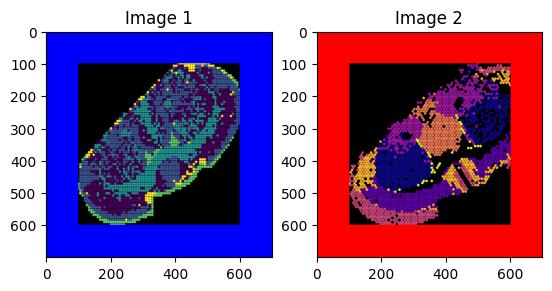

Transformation Matrix:
 [[ 0.83825782  0.01606478  5.22333114]
 [ 0.00963012  0.99511928 -6.98474502]]


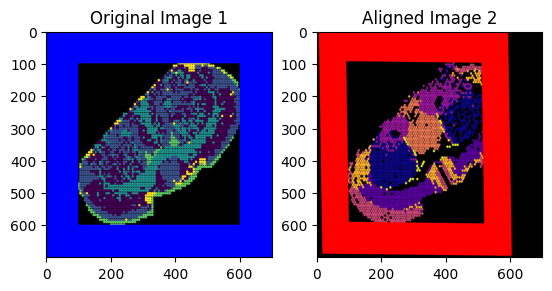

In [122]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm

def create_image_from_data(data, width=500, height=500, dot_size=5, border_size=50, dot_colors=None, border_color=(0, 0, 0), colormap='viridis'):
    """
    Create an image from 2D data points with specified dot size, border size, and colors.

    Parameters:
    - data: 2D numpy array where data[0] contains x coordinates and data[1] contains y coordinates
    - width: Width of the image
    - height: Height of the image
    - dot_size: Size of the dots
    - border_size: Size of the border around the image
    - dot_colors: List of scalar values for each dot, which will be mapped to colors using a colormap
    - border_color: Color of the border (BGR format)
    - colormap: Colormap to use for mapping scalar values to colors
    
    Returns:
    - bordered_image: Image with data points and border
    """
    # Initialize an empty image with three channels for color
    image = np.zeros((height, width, 3), dtype=np.uint8)

    # Normalize data points to image dimensions
    x_norm = np.interp(data[0], (data[0].min(), data[0].max()), (0, width-1))
    y_norm = np.interp(data[1], (data[1].min(), data[1].max()), (0, height-1))

    # Normalize dot_colors to [0, 1] range
    if dot_colors is not None:
        norm = plt.Normalize(vmin=min(dot_colors), vmax=max(dot_colors))
        cmap = cm.get_cmap(colormap)
        mapped_colors = cmap(norm(dot_colors))

    # Draw circles at normalized positions
    for i, (x, y) in enumerate(zip(x_norm, y_norm)):
        if dot_colors is not None:
            color = (mapped_colors[i][:3] * 255).astype(int)  # Convert to BGR format
            color = tuple(map(int, color[::-1]))  # Convert from RGB to BGR
        else:
            color = (255, 255, 255)  # Default white color
        cv2.circle(image, (int(x), int(y)), dot_size, color, -1)  # -1 means filled circle

    # Add border
    bordered_image = cv2.copyMakeBorder(image, border_size, border_size, border_size, border_size, 
                                        cv2.BORDER_CONSTANT, value=border_color)

    return bordered_image

# Simulated scalar values
dot_colors_1 = data1_leiden_str.astype(int)
dot_colors_2 = data2_leiden_str.astype(int)

# Create images
img1 = create_image_from_data(data3_spatial_results, width=500, height=500, dot_size=4, border_size=100, dot_colors=dot_colors_1, border_color=(255, 0, 0), colormap='viridis')
img2 = create_image_from_data(data2_spatial_results, width=500, height=500, dot_size=4, border_size=100, dot_colors=dot_colors_2, border_color=(0, 0, 255), colormap='plasma')

# Display images using matplotlib
plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(img1, cv2.COLOR_BGR2RGB))
plt.title('Image 1')

plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(img2, cv2.COLOR_BGR2RGB))
plt.title('Image 2')

plt.show()


import cv2
import numpy as np
import matplotlib.pyplot as plt

# Lists to store points
points_image1 = []
points_image2 = []

def click_event_image1(event, x, y, flags, param):
    if event == cv2.EVENT_LBUTTONDOWN:
        points_image1.append((x, y))
        cv2.circle(img1_display, (x, y), 5, (0, 255, 0), -1)
        cv2.imshow('Image 1', img1_display)

def click_event_image2(event, x, y, flags, param):
    if event == cv2.EVENT_LBUTTONDOWN:
        points_image2.append((x, y))
        cv2.circle(img2_display, (x, y), 5, (0, 255, 0), -1)
        cv2.imshow('Image 2', img2_display)

def compute_affine_transform(points_image1, points_image2):
    pts1 = np.float32(points_image1)
    pts2 = np.float32(points_image2)
    M = cv2.getAffineTransform(pts2[:3], pts1[:3])  # Use the first 3 points for affine transform
    return M

def warp_image(image, M, output_shape):
    warped_image = cv2.warpAffine(image, M, output_shape)
    return warped_image

# Load images
img1_display = img1.copy()
img2_display = img2.copy()

# Display images and set mouse callbacks
cv2.imshow('Image 1', img1_display)
cv2.imshow('Image 2', img2_display)
cv2.setMouseCallback('Image 1', click_event_image1)
cv2.setMouseCallback('Image 2', click_event_image2)

# Wait until 6 points are selected (3 from each image)
while len(points_image1) < 3 or len(points_image2) < 3:
    cv2.waitKey(1)

cv2.destroyAllWindows()

# Compute the transformation matrix
M = compute_affine_transform(points_image1, points_image2)
print("Transformation Matrix:\n", M)

# Apply the transformation to the second image
rows, cols = img1.shape[:2]
aligned_image = warp_image(img2, M, (cols, rows))

# Display the original and aligned images
plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(img1, cv2.COLOR_BGR2RGB))
plt.title('Original Image 1')

plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(aligned_image, cv2.COLOR_BGR2RGB))
plt.title('Aligned Image 2')
plt.show()


               0           1            2
0     133.650207  128.863188   -61.497229
1      16.967602  150.963481  -960.884088
2     121.341250   31.898118   546.705764
3     151.822943  115.751453   147.045418
4      29.154043  105.495736  -561.354882
...          ...         ...          ...
2215   97.879257   77.165721    76.803701
2216   49.342442  148.851526  -739.803700
2217   32.493233  153.924317  -882.998939
2218   27.835366  113.534773  -626.672071
2219   48.365034  189.149021 -1031.357865

[2220 rows x 3 columns]
               0      1
0     162.162162    0.0
1     159.459459    0.0
2     156.756757    0.0
3     154.054054    0.0
4     151.351351    0.0
...          ...    ...
3079   51.351351  200.0
3080   48.648649  200.0
3081   45.945946  200.0
3082   43.243243  200.0
3083   40.540541  200.0

[3084 rows x 2 columns]


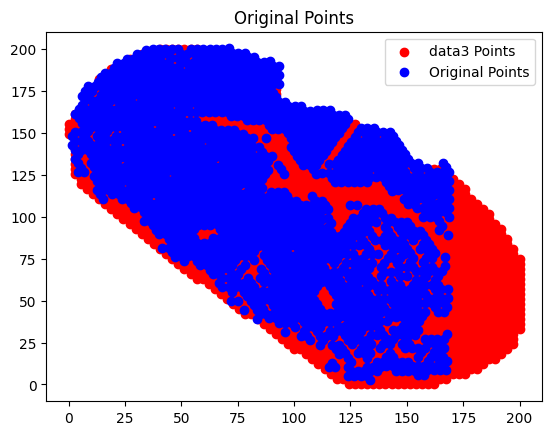

In [123]:
M_homogeneous = np.vstack([M, [0, 0, 1]])

# Convert DataFrame to homogeneous coordinates
coordinates_data3 = data3_spatial_results  # Add a column of 1s
coordinates_data2 = data2_spatial_results  # Add a column of 1s

# Apply the transformation matrix
#transformed_coordinates_data3 = coordinates_data3.dot(M_homogeneous.T)
transformed_coordinates_data2 = coordinates_data2.dot(M)
# Update the DataFrame with the transformed coordinates
print(transformed_coordinates_data2)
print(data3_spatial_results)
plt.title('Original Points')
plt.scatter(data3_spatial_results[0], data3_spatial_results[1], color='red', label='data3 Points')
plt.scatter(transformed_coordinates_data2[0], transformed_coordinates_data2[1], color='blue', label='Original Points')


plt.legend()

In [124]:
print(transformed_coordinates_data2)
data2_spatial_results = transformed_coordinates_data2.iloc[:,0:2]
print(data2_spatial_results)

               0           1            2
0     133.650207  128.863188   -61.497229
1      16.967602  150.963481  -960.884088
2     121.341250   31.898118   546.705764
3     151.822943  115.751453   147.045418
4      29.154043  105.495736  -561.354882
...          ...         ...          ...
2215   97.879257   77.165721    76.803701
2216   49.342442  148.851526  -739.803700
2217   32.493233  153.924317  -882.998939
2218   27.835366  113.534773  -626.672071
2219   48.365034  189.149021 -1031.357865

[2220 rows x 3 columns]
               0           1
0     133.650207  128.863188
1      16.967602  150.963481
2     121.341250   31.898118
3     151.822943  115.751453
4      29.154043  105.495736
...          ...         ...
2215   97.879257   77.165721
2216   49.342442  148.851526
2217   32.493233  153.924317
2218   27.835366  113.534773
2219   48.365034  189.149021

[2220 rows x 2 columns]


In [257]:
cca = CCA(n_components=2)
cca.fit(data1_spatial_results,data2_spatial_results)
data1_spatial_results_cca = cca.transform(data1_spatial_results)
data2_spatial_results_cca = cca.transform(data2_spatial_results)
data3_spatial_results_cca = cca.transform(data3_spatial_results)
data1_spatial_results_cca=pd.DataFrame(data1_spatial_results_cca)
data2_spatial_results_cca=pd.DataFrame(data2_spatial_results_cca)
data3_spatial_results_cca=pd.DataFrame(data3_spatial_results_cca)

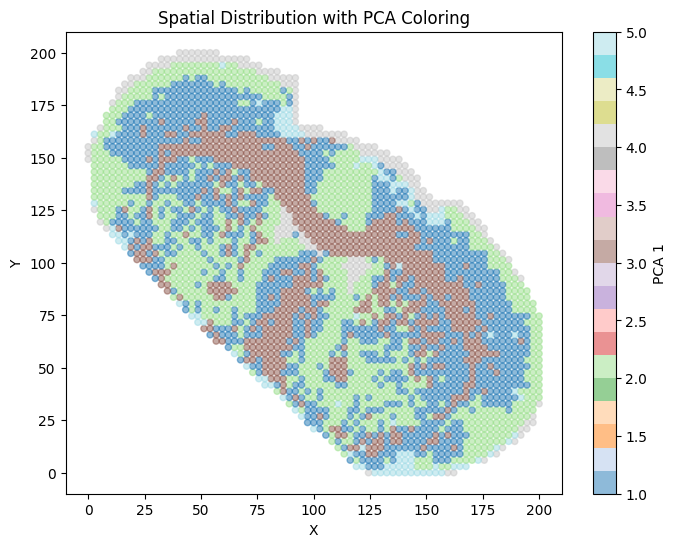

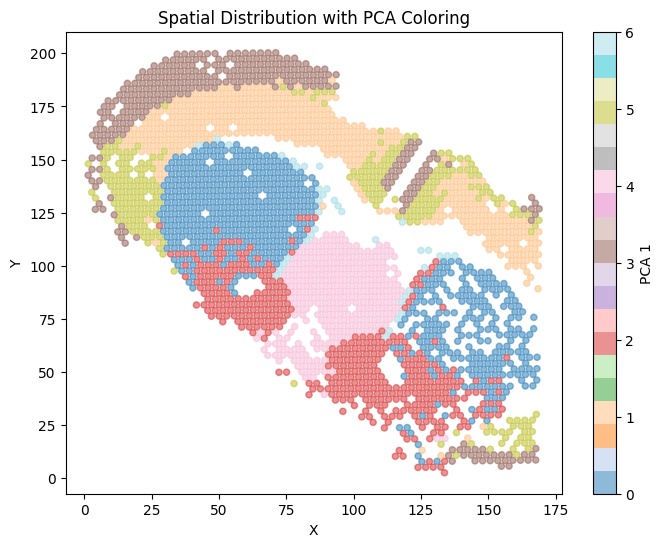

In [125]:
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 6))
plt.scatter(data3_spatial_results.iloc[:, 0], data3_spatial_results.iloc[:, 1], c=data1_leiden_str.astype(int), cmap='tab20', s=20, alpha=0.5)
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Spatial Distribution with PCA Coloring')
plt.colorbar(label='PCA 1')
plt.show()
plt.figure(figsize=(8, 6))
plt.scatter(data2_spatial_results.iloc[:, 0], data2_spatial_results.iloc[:, 1], c=data2_leiden_str.astype(int), cmap='tab20', s=20, alpha=0.5)
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Spatial Distribution with PCA Coloring')
plt.colorbar(label='PCA 1')
plt.show()

In [126]:
####select nearst neighbour of sample pairs between X1 and X3
####
color_mapping = {
    0: 'blue',
    1: 'red',
    2: 'green',
    3: 'yellow',
    4: 'orange',
    5: 'purple',
    6: 'brown',
    7: 'pink',
    8: 'gray',
    9: 'cyan',
    10: 'magenta',
    11: 'magenta'
}
Y_c = data2_spatial_results
Z_c = data3_spatial_results
print(Z_c.shape, Y_c.shape)
from scipy.spatial.distance import cdist
distances = cdist(Z_c, Y_c, metric='euclidean')
dist_df = pd.DataFrame(distances)
print(dist_df.shape)
min_row_indices = dist_df.idxmin()
print(Z_c.shape, Y_c.shape)
###############找出Y_C(spatial)周围dist_min以内的Z_C(metabolic)点
Y_C_ = Y_c.iloc[:,:]
Y_C_['spatial_ID'] = Y_C_.index
Y_C_ = Y_C_.reset_index()
Y_C_["spatial_cluster"] = data2_leiden_str.astype(int)
Y_C_["spatial.CCA.Z"] = -1
Y_C_ = Y_C_.drop(columns=['index'])
Y_C_ = Y_C_.rename(columns={0: "spatial.CCA.X", 1:"spatial.CCA.Y"})
print(Z_c.shape, Y_c.shape)
Z_C_=Z_c.iloc[min_row_indices,]
Z_C_['matabolic_ID'] = Z_C_.index
Z_C_=Z_C_.reset_index()
Z_C_["matabolic_cluster"] = data1_leiden_str[min_row_indices].astype(int)
Z_C_=Z_C_.drop(columns=['index'])
Z_C_["matabolic.CCA.Z"] = 1
Z_C_=Z_C_.rename(columns={0: "metabolic.CCA.X", 1:"metabolic.CCA.Y"})
pairs = pd.concat([Y_C_,Z_C_],axis=1)
#pairs["distance"] = dist_df.iloc[row_indices,col_indices].values.diagonal()  //diagonal要求内存过大
print(pairs.head())


(3084, 2) (2220, 2)
(3084, 2220)
(3084, 2) (2220, 2)
(3084, 2) (2220, 2)
   spatial.CCA.X  spatial.CCA.Y  spatial_ID  spatial_cluster  spatial.CCA.Z  \
0     133.650207     128.863188           0                1             -1   
1      16.967602     150.963481           1                5             -1   
2     121.341250      31.898118           2                2             -1   
3     151.822943     115.751453           3                1             -1   
4      29.154043     105.495736           4                5             -1   

   metabolic.CCA.X  metabolic.CCA.Y  matabolic_ID  matabolic_cluster  \
0       132.432432       128.358209          2131                  1   
1        16.216216       152.238806          2599                  1   
2       121.621622        32.835821           357                  2   
3       151.351351       116.417910          1878                  1   
4        29.729730       104.477612          1678                  3   

   matabolic.CCA.Z 

C:\Users\28123\AppData\Local\Temp\ipykernel_18968\3394193823.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Z_C_['matabolic_ID'] = Z_C_.index


C:\Users\28123\AppData\Local\Temp\ipykernel_18968\289822106.py:2: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(data2_spatial_results.iloc[:, 0], data2_spatial_results.iloc[:, 1],  c=[color_mapping[category] for category in data2_leiden_str.astype(int)], cmap='tab20', s=20, alpha=0.5)


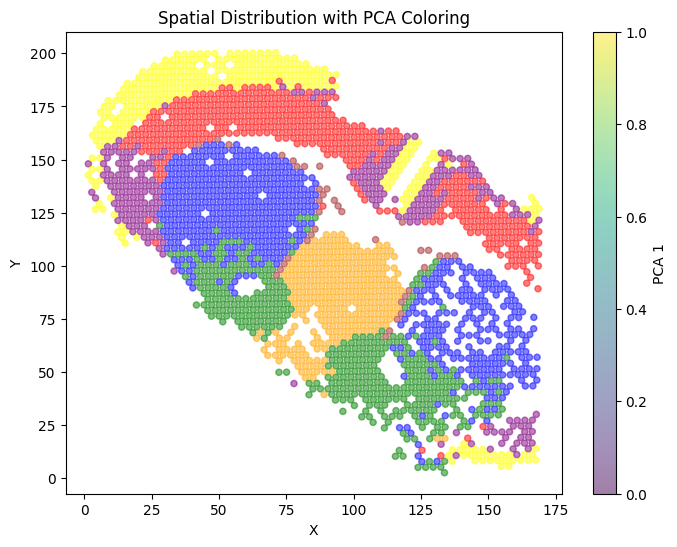

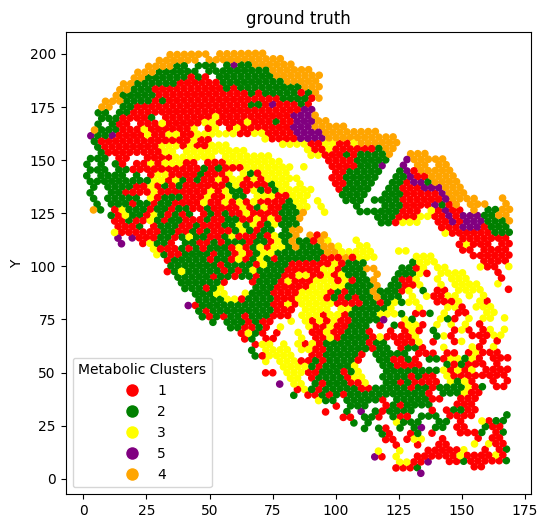

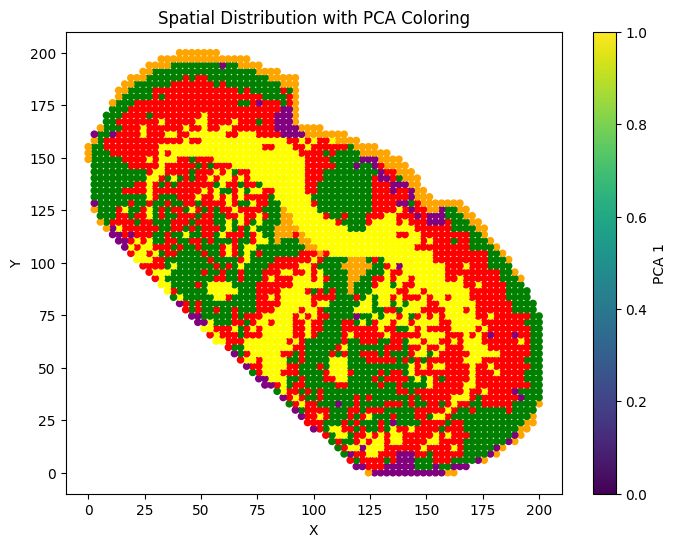

In [130]:
plt.figure(figsize=(8, 6))
plt.scatter(data2_spatial_results.iloc[:, 0], data2_spatial_results.iloc[:, 1],  c=[color_mapping[category] for category in data2_leiden_str.astype(int)], cmap='tab20', s=20, alpha=0.5)
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Spatial Distribution with PCA Coloring')
plt.colorbar(label='PCA 1')
plt.show()
plt.figure(figsize=(6, 6))
plt.scatter(data2_spatial_results.iloc[:, 0],data2_spatial_results.iloc[:, 1], 
            c=[color_mapping[category] for category in pairs["matabolic_cluster"].tolist()], s=20, alpha=1)
plt.ylabel('Y')
plt.title('ground truth')
unique_categories = pairs["matabolic_cluster"].unique()
handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color_mapping[cat], markersize=10) for cat in unique_categories]
plt.legend(handles, unique_categories, title="Metabolic Clusters")
plt.savefig("I:\\mutiomics\\Spatial Multimodal Analysis of Transcriptomes and Metabolomes in Tissues\\m3\\ground truth.pdf")
plt.show()
plt.figure(figsize=(8, 6))
plt.scatter(data3_spatial_results.iloc[:, 0], data3_spatial_results.iloc[:, 1], c=[color_mapping[category] for category in data1_leiden_str.astype(int)], s=20, alpha=1)
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Spatial Distribution with PCA Coloring')
plt.colorbar(label='PCA 1')
plt.show()

In [129]:
pairs.to_csv("I:\\mutiomics\\Spatial Multimodal Analysis of Transcriptomes and Metabolomes in Tissues\\m3\\pair_groundtruth.csv", index=False)